In [1]:
%config Completer.use_jedi = False

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

In [2]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [6]:
data_file = 'criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

n_campaigns = 400

def lta_df(df):
    df0 = df
    df1 = add_derived_columns(df0)
    df2 = sample_campaigns(df1, n_campaigns)
    df3 = filter_journeys_by_length(df2, 2)
    df4 = balance_conversions(df3)
    df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
    df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])
    return df6
df6 = lta_df(df0)
print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

571483
[285858, 285625]


In [4]:

def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

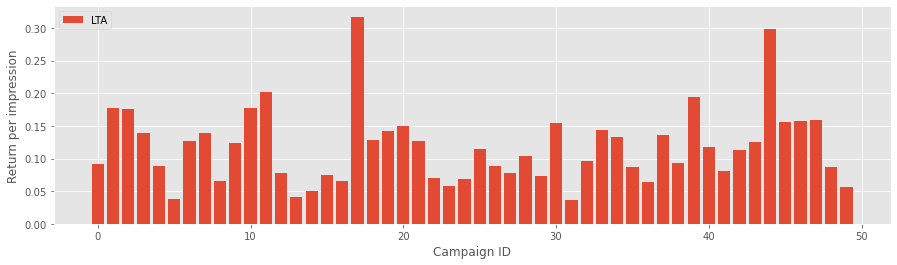

In [5]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [6]:
def linear_model(df):
    df = df6
    # Filter the data frame of uid which has conversion ==1 
    df_conv = df6[df6['uid'].isin(df6[df6['conversion'] == 1].uid.unique())]
    # Creating a dataframe conatinng the total count of each campaigin in a particualr jid
    df_count = df_conv.groupby('jid')['campaign'].nunique().reset_index(name = 'count')
    # groupby jid and campaign to merge with count data frame later
    df_t = df_conv.groupby(['jid', 'campaign']).size().reset_index(name='Freq')#.sort_values(by = 'jid')
    df_merge = pd.merge(df_count,df_t)
    # Identifying each indivudal campaign weights
    df_merge['linear_weights'] = 1/df_merge['count']
    # creating a final data frame consisting of weights from individual campaigns 
    linear_df = df_merge.groupby('campaign')['linear_weights'].agg('sum').reset_index(name = 'weight')
    totalCampaign = df6.groupby(['campaign'])['campaign'].count().reset_index(name = 'count')
    linear_df = pd.merge(totalCampaign, linear_df)
    linear_model = np.array(linear_df['weight']/linear_df['count'])
    return linear_model

In [8]:
lm = linear_model(df6)

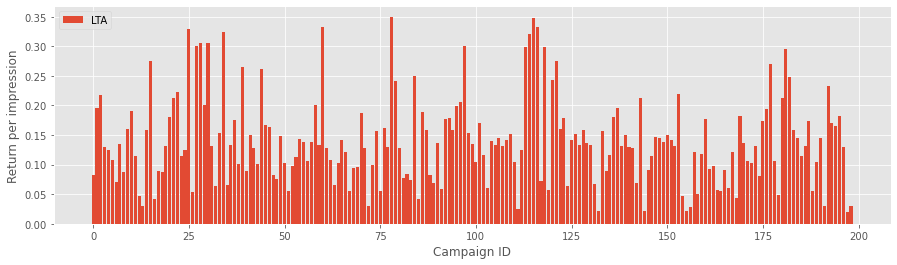

In [9]:
campaign_idx = range(1, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lm[campaign_idx])), lm[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [29]:
# time decay attribution model
# belwo is the column which can be used to calculate the days since last clicked 
(df6.time_since_last_click/86400).reset_index(name ='d').sort_values(by = 'd', ascending = False)

,index,d
561791,121278,29.9999
339291,365815,29.9994
318467,522963,29.9993
317415,480718,29.9993
483439,560131,29.9986
...,...,...
261629,39131,-1.15741e-05
261636,195531,-1.15741e-05
499226,164126,-1.15741e-05
261665,179225,-1.15741e-05


U shaped attribution model

In [31]:
df = df6
# Filter the data frame of uid which has conversion ==1 



In [ ]:
def linear_model(df):
    df = df6
    # Filter the data frame of uid which has conversion ==1 
    df_conv = df6[df6['uid'].isin(df6[df6['conversion'] == 1].uid.unique())]
    # Creating a dataframe conatinng the total count of each campaigin in a particualr jid
    df_count = df_conv.groupby('jid')['campaign'].nunique().reset_index(name = 'count')
    # groupby jid and campaign to merge with count data frame later
    df_t = df_conv.groupby(['jid', 'campaign']).size().reset_index(name='Freq')#.sort_values(by = 'jid')
    df_merge = pd.merge(df_count,df_t)
    # Identifying each indivudal campaign weights
    df_merge['linear_weights'] = 1/df_merge['count']
    # creating a final data frame consisting of weights from individual campaigns 
    linear_df = df_merge.groupby('campaign')['linear_weights'].agg('sum').reset_index(name = 'weight')
    totalCampaign = df6.groupby(['campaign'])['campaign'].count().reset_index(name = 'count')
    linear_df = pd.merge(totalCampaign, linear_df)
    linear_model = np.array(linear_df['weight']/linear_df['count'])
    return linear_model
lm = linear_model(df6)

In [104]:
def uShapeAttri(df):
    df6 = df
    df_conv = df6.copy()#df6[df6['uid'].isin(df6[df6['conversion'] == 1].uid.unique())]
    idx1 = df_conv.groupby(['jid'])['timestamp_norm'].transform(min)
    idx2 = df_conv.groupby(['jid'])['timestamp_norm'].transform(max) 
    df1 = df_conv[df_conv['timestamp_norm'].isin(idx2)]
    df2 = df_conv[df_conv['timestamp_norm'].isin(idx2)]
    df1 = pd.concat([df1,df2])
    df1['weight'] = .20
    df1 = df1[['jid', 'campaign', 'weight']]
    ### Creating a data frame for the middle camapigns in each jid 
    df2 = df_conv[~df['timestamp_norm'].isin(idx2)]
    df_count = df2.groupby('jid')['campaign'].nunique().reset_index(name = 'count')
    df_t = df2.groupby(['jid', 'campaign']).size().reset_index(name='Freq')
    df_merge = pd.merge(df_count,df_t)
    # Identifying each indivudal campaign weights
    df_merge['weight'] = 0.6/df_merge['count']
    df_merge = df_merge[['jid', 'campaign','weight']]
    # Concating the dataframe for both First and Last touch points weights with the middle weight 
    df = pd.concat([df1,df_merge]) 
    return df

uDf = uShapeAttri(df6)
uDf = uDf.groupby('campaign')['weight'].agg('sum').reset_index(name = 'weight')
# Creating the total campaign data frame
totalCampaign = df6.groupby(['campaign'])['campaign'].count().reset_index(name = 'count')
uDf = pd.merge(totalCampaign, uDf)
# Creating final utouch model 
uTouchModel = np.array(uDf['weight']/uDf['count'])


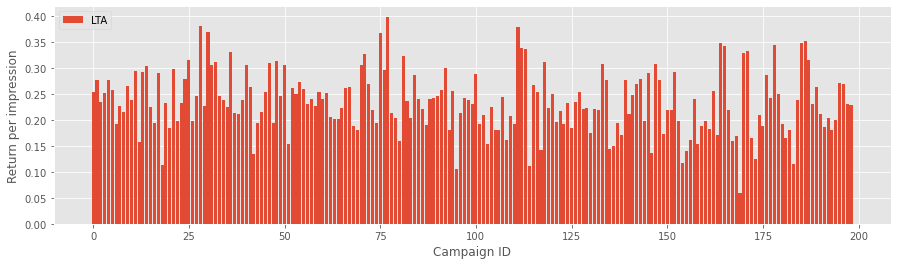

In [105]:
campaign_idx = range(1, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(uTouchModel[campaign_idx])), uTouchModel[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [108]:
df6.head(1).T

,249912
timestamp,2
uid,28474333
campaign,18975823
conversion,0
conversion_timestamp,-1
conversion_id,-1
attribution,0
click,0
click_pos,-1
click_nb,-1


In [107]:
len(uTouchModel)

400

In [67]:
df_conv[df_conv['timestamp_norm'].isin(idx2)]

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
268697,498,8361406,2946551,1,815,13161205,1,1,3,4,...,11409684,1973606,25066554,26597096,16022563,8361406_13161205,0.000186,1.323302e-04,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
247958,1024,11676091,15321102,1,1321,2184732,1,1,4,5,...,11409686,28928366,27594281,29196072,16022558,11676091_2184732,0.000383,7.986108e-05,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
148348,1687,28428220,497593,1,8129,15368290,1,1,2,3,...,11409686,5824235,17477527,29196072,23549935,28428220_15368290,0.000632,7.716046e-07,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
394148,1701,7916416,30491418,1,175877,6557803,1,1,2,3,...,5824237,28928366,6179461,29196072,6083947,7916416_6557803,0.000637,4.170523e-04,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
446934,2455,15086999,15184511,0,-1,-1,0,0,-1,-1,...,5824235,1973606,32081193,29841067,32145483,15086999_-1,0.000919,8.804009e-04,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393535,2671171,21464622,14121532,1,4738990,15614650,0,1,1,3,...,11409686,28928366,25063773,29196072,29520626,21464622_15614650,0.999990,4.621410e-02,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
202034,2671172,32118557,15398570,1,2973215,8167674,1,1,2,4,...,32440044,29196072,14573904,29196072,9491351,32118557_8167674,0.999990,8.626926e-03,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
146452,2671176,19065515,8980584,1,4656976,24966585,0,1,4,7,...,11409686,1973606,2624617,26597096,21091111,19065515_24966585,0.999991,1.683483e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
530434,2671178,11373089,2946551,1,4574535,18502870,0,1,2,4,...,11409684,1973606,25066554,26597096,8661623,11373089_18502870,0.999992,1.825524e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [70]:
t = df_conv[df_conv['timestamp_norm'].isin(idx1)]
t1 = df_conv[df_conv['timestamp_norm'].isin(idx2)]
#pd.concat(,)


In [75]:
pd.concat([t,t1])

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
435641,25,6013772,15184511,1,138469,15587012,0,1,1,6,...,5824235,32440044,32081193,29196072,6083952,6013772_15587012,0.000009,0.000207,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
275674,35,6214101,32452111,0,-1,-1,0,1,-1,-1,...,5824237,29196072,6288950,29196072,29520626,6214101_-1,0.000013,0.042760,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
521734,36,32131776,30491418,0,-1,-1,0,0,-1,-1,...,5824237,28928366,6179461,29196072,29520626,32131776_-1,0.000013,0.046811,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
340217,42,5236926,9100691,0,-1,-1,0,0,-1,-1,...,26611395,1973606,30678301,29196072,16022558,5236926_-1,0.000016,0.000093,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
341587,45,22000711,25419531,0,-1,-1,0,1,-1,-1,...,32440044,1973606,2053513,26597096,21091108,22000711_-1,0.000017,0.084894,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393535,2671171,21464622,14121532,1,4738990,15614650,0,1,1,3,...,11409686,28928366,25063773,29196072,29520626,21464622_15614650,0.999990,0.046214,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
202034,2671172,32118557,15398570,1,2973215,8167674,1,1,2,4,...,32440044,29196072,14573904,29196072,9491351,32118557_8167674,0.999990,0.008627,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
146452,2671176,19065515,8980584,1,4656976,24966585,0,1,4,7,...,11409686,1973606,2624617,26597096,21091111,19065515_24966585,0.999991,0.168348,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
530434,2671178,11373089,2946551,1,4574535,18502870,0,1,2,4,...,11409684,1973606,25066554,26597096,8661623,11373089_18502870,0.999992,0.182552,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [53]:
df_conv.groupby(['jid'])['timestamp_norm'].transform(min).index

Int64Index([435641, 275674, 521734, 340217, 341587, 120246, 503933,  10643,
            496990, 330459,
            ...
            528587, 268430, 368849, 497640, 530564, 393535, 202034, 146452,
            530434, 355942],
           dtype='int64', length=309863)

In [64]:
df_conv[~df_conv['timestamp_norm'].isin(idx2)]


,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
435641,25,6013772,15184511,1,138469,15587012,0,1,1,6,...,5824235,32440044,32081193,29196072,6083952,6013772_15587012,0.000009,0.000207,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
275674,35,6214101,32452111,0,-1,-1,0,1,-1,-1,...,5824237,29196072,6288950,29196072,29520626,6214101_-1,0.000013,0.042760,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
521734,36,32131776,30491418,0,-1,-1,0,0,-1,-1,...,5824237,28928366,6179461,29196072,29520626,32131776_-1,0.000013,0.046811,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
340217,42,5236926,9100691,0,-1,-1,0,0,-1,-1,...,26611395,1973606,30678301,29196072,16022558,5236926_-1,0.000016,0.000093,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
341587,45,22000711,25419531,0,-1,-1,0,1,-1,-1,...,32440044,1973606,2053513,26597096,21091108,22000711_-1,0.000017,0.084894,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432598,2670587,6311166,13365547,1,2756318,19796067,0,1,3,8,...,11409684,1973606,23653954,20754144,6083947,6311166_19796067,0.999771,0.000276,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
504851,2670685,20457158,4869923,1,4734982,31488704,1,1,0,5,...,5824236,1973606,906512,26597096,18291877,20457158_31488704,0.999808,0.632197,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
491645,2670713,21257896,9700343,1,4118859,13055598,1,1,1,5,...,32440044,28928366,17486673,29196072,29520629,21257896_13055598,0.999818,0.033856,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
557994,2670880,3226993,28351001,1,2671923,24099016,0,1,10,13,...,5824236,29196072,16628728,29196072,6083952,3226993_24099016,0.999881,0.000191,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
268697,498,8361406,2946551,1,815,13161205,1,1,3,4,...,11409684,1973606,25066554,26597096,16022563,8361406_13161205,0.000186,1.323302e-04,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
247958,1024,11676091,15321102,1,1321,2184732,1,1,4,5,...,11409686,28928366,27594281,29196072,16022558,11676091_2184732,0.000383,7.986108e-05,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
148348,1687,28428220,497593,1,8129,15368290,1,1,2,3,...,11409686,5824235,17477527,29196072,23549935,28428220_15368290,0.000632,7.716046e-07,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
394148,1701,7916416,30491418,1,175877,6557803,1,1,2,3,...,5824237,28928366,6179461,29196072,6083947,7916416_6557803,0.000637,4.170523e-04,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
446934,2455,15086999,15184511,0,-1,-1,0,0,-1,-1,...,5824235,1973606,32081193,29841067,32145483,15086999_-1,0.000919,8.804009e-04,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393535,2671171,21464622,14121532,1,4738990,15614650,0,1,1,3,...,11409686,28928366,25063773,29196072,29520626,21464622_15614650,0.999990,4.621410e-02,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
202034,2671172,32118557,15398570,1,2973215,8167674,1,1,2,4,...,32440044,29196072,14573904,29196072,9491351,32118557_8167674,0.999990,8.626926e-03,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
146452,2671176,19065515,8980584,1,4656976,24966585,0,1,4,7,...,11409686,1973606,2624617,26597096,21091111,19065515_24966585,0.999991,1.683483e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
530434,2671178,11373089,2946551,1,4574535,18502870,0,1,2,4,...,11409684,1973606,25066554,26597096,8661623,11373089_18502870,0.999992,1.825524e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## idx1

In [36]:
# Creating a dataframe conatinng the total count of each campaigin in a particualr jid
df_count = df_conv.groupby('jid')['campaign'].nunique().reset_index(name = 'count')
df_t = df_conv.groupby(['jid', 'campaign']).size().reset_index(name='Freq')#.sort_values(by = 'jid')
df_merge = pd.merge(df_count,df_t)

In [89]:
df_merge

,jid,count,campaign,Freq
0,10000403_29178244,1,15398570,2
1,10000523_19113736,1,3466867,4
2,10000523_2559380,1,3466867,3
3,1000095_27795443,1,15398570,2
4,10001676_25144611,1,3828360,3
...,...,...,...,...
80510,9999669_4594367,1,21294794,2
80511,9999681_20315908,1,12843316,2
80512,9999748_-1,1,15184511,21
80513,9999748_25873601,1,15184511,11


In [ ]:
# Creating a dataframe conatinng the total count of each campaigin in a particualr jid
df_count = df_conv.groupby('jid')['campaign'].nunique().reset_index(name = 'count')
# groupby jid and campaign to merge with count data frame later
df_t = df_conv.groupby(['jid', 'campaign']).size().reset_index(name='Freq')#.sort_values(by = 'jid')
df_merge = pd.merge(df_count,df_t)

Below is for time decay model


In [31]:
import random

random.seed(10)

dft = df6[['uid', 'jid', 'campaign','conversion', 'click','timestamp_norm']].sort_values(by = 'uid').sample(20000)

In [33]:
dft[['uid', 'jid', 'campaign','conversion', 'click','timestamp_norm']].sort_values(by = 'uid').w

,uid,jid,campaign,conversion,click,timestamp_norm
302441,1827,1827_1208288,604244,1,1,0.187057
400900,2386,2386_-1,13422843,0,1,0.429955
95343,2613,2613_20401740,11097337,1,1,0.947598
121660,4659,4659_23795260,5544859,1,1,0.040516
161374,6815,6815_7126597,31772643,1,1,0.626766
...,...,...,...,...,...,...
371853,32442346,32442346_-1,26321366,0,0,0.391782
301624,32442869,32442869_-1,32009848,0,0,0.377718
599701,32442952,32442952_16781453,3892353,1,1,0.690001
122065,32451750,32451750_337509,15491650,1,1,0.563096


In [18]:
import datetime


In [20]:
df6.timestamp

249912          2
14819           2
423411          3
310576          4
308680          4
           ...   
393535    2671171
202034    2671172
146452    2671176
530434    2671178
355942    2671178
Name: timestamp, Length: 571483, dtype: object